In [7]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
from langgraph.types import Command


llm = init_chat_model("openai:gpt-5-mini-2025-08-07")

dumb_llm = init_chat_model("openai:gpt-5-nano-2025-08-07")
average_llm = init_chat_model("openai:gpt-5-mini-2025-08-07")
smart_llm = init_chat_model("openai:gpt-5.2-2025-12-11")

In [8]:
class State(TypedDict):
    question: str
    difficulty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):
    difficulty_level: Literal["easy", "medium", "hard"]


In [9]:
def dumb_node(state: State) -> State:
    response = dumb_llm.invoke(f"Answer the following question: {state['question']}")

    return {
        "answer": response.content,
        "model_used": "gpt-5-nano",
    }


def average_node(state: State) -> State:
    response = average_llm.invoke(f"Answer the following question: {state['question']}")

    return {
        "answer": response.content,
        "model_used": "gpt-5-mini",
    }


def smart_node(state: State) -> State:
    response = smart_llm.invoke(f"Answer the following question: {state['question']}")

    return {
        "answer": response.content,
        "model_used": "gpt-5.2",
    }


def assess_difficulty(state: State) -> State:
    structured_llm = llm.with_structured_output(DifficultyResponse)

    response = structured_llm.invoke(
        f"""
        Assess the difficulty of the following question:
        Question: {state["question"]}

        - Easy: The question is straightforward and can be answered by a basic understanding of the subject.
        - Medium: The question requires a moderate level of knowledge and understanding of the subject.
        - Hard: The question is complex and requires a deep understanding of the subject.
        """,
    )

    difficulty_level = response.difficulty_level

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    else:
        goto = "smart_node"

    return Command(
        goto=goto,
        update={"difficulty": difficulty_level},
    )


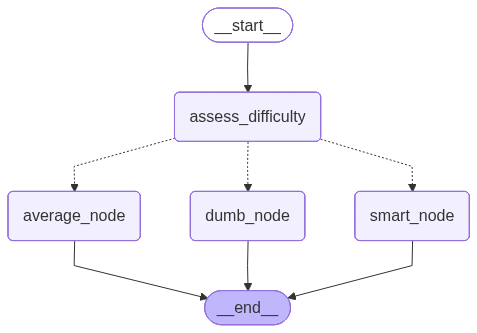

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=[
        "dumb_node",
        "average_node",
        "smart_node",
    ],
)


graph_builder.add_edge(START, "assess_difficulty")


graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("smart_node", END)

graph = graph_builder.compile()

graph


In [ ]:
graph.invoke({"question": "양자 얽힘의 원리는?"})

{'question': '양자 얽힘의 원리는?',
 'difficulty': 'medium',
 'answer': '양자 얽힘(quantum entanglement)은 양자역학의 핵심 현상 중 하나로, 두 개 이상 양자계의 상태가 서로 독립적으로 기술될 수 없고 하나의 전체 상태로만 기술되는 상황을 말합니다. 핵심 내용은 다음과 같습니다.\n\n- 정의와 수학적 특징\n  - 두 계 A와 B의 전체 상태는 텐서곱(H_A ⊗ H_B)에 속합니다. 만약 전체 상태 |Ψ⟩가 어떤 단일계의 상태들의 곱(|ψ_A⟩ ⊗ |φ_B⟩)으로 쓸 수 없다면 그 상태는 얽혀있다고 합니다(비가분적 상태).\n  - 예: 스핀-1/2 두 입자의 싱글렛 상태\n    |Ψ−⟩ = (|↑↓⟩ − |↓↑⟩)/√2\n    이 상태에서는 각 입자의 개별 상태를 정해 말할 수 없지만, 두 입자의 측정 결과는 강하게 반대입니다.\n\n- 생성\n  - 상호작용(예: 충돌, 상자 안에서의 상호작용, 광자 쌍 생성 등)을 통해 계들이 얽히게 됩니다. 보존법칙(총스핀, 총에너지 등)이 얽힘의 구조를 결정하는 경우가 많습니다.\n  - 일단 얽히면 물리적으로 멀리 떨어져도 전체 상태는 유지됩니다(외부 간섭·상호작용이 없을 때).\n\n- 측정과 상관관계\n  - 한 쪽을 측정하면 전체 파동함수가 붕괴하면서 다른 쪽의 결과와 강하게 상관된 결과가 즉시 결정됩니다. 예컨대 싱글렛에서 한 쪽이 ↑로 나오면 다른 쪽은 반드시 ↓입니다.\n  - 이 상관관계는 거리와 무관하게 나타나므로 “비국소적 상관(nonlocal correlation)”이라고 불립니다.\n\n- 벨(Bell) 부등식과 현실성·국소성\n  - 존 벨의 이론은 얽힌 계열에서의 상관이 국소적 실재론(local realism) 가정을 만족하는 숨은변수 모형으로 설명될 수 없음을 보여줍니다. 실험들은 벨 부등식을 위배하여 양자역학의 비국소적 예측을 지지합니다.\n\n- 초광속 통신 불가(no-signaling)\n  - 얽힘은 먼 거리의 측정 결